# Can we use the Federal Prime Lending Rate to predict Mutual Fund Performance?

In [459]:
import yfinance as yf
import pandas as pd
import requests
import pickle
from bs4 import BeautifulSoup
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts

import warnings


%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Yahoo Finance Data on the XLV Fund

In [460]:
xlv = yf.Ticker('XLV')
xlv_hist = xlv.history(period = 'max', actions = False)
xlv_hist['Change'] = xlv_hist['Close'] - xlv_hist['Open']
xlv_hist['Volume'] = xlv_hist.Volume.astype('float64')
xlv_hist.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-12-22,18.41,18.60,18.41,18.58,5700.0,0.17
1998-12-23,18.69,18.99,18.69,18.99,18100.0,0.30
1998-12-24,19.02,19.11,18.94,19.11,4900.0,0.09
1998-12-28,19.05,19.11,18.83,18.83,15500.0,-0.22
1998-12-29,18.83,19.25,18.83,19.25,5300.0,0.42


In [461]:
xlv_hist = xlv_hist.iloc[::-1]
xlv_hist_monthly = xlv_hist['Close'].resample('MS')
xlv_monthly_mean = xlv_hist_monthly.mean()
xlv_monthly_mean.isnull().sum()

0

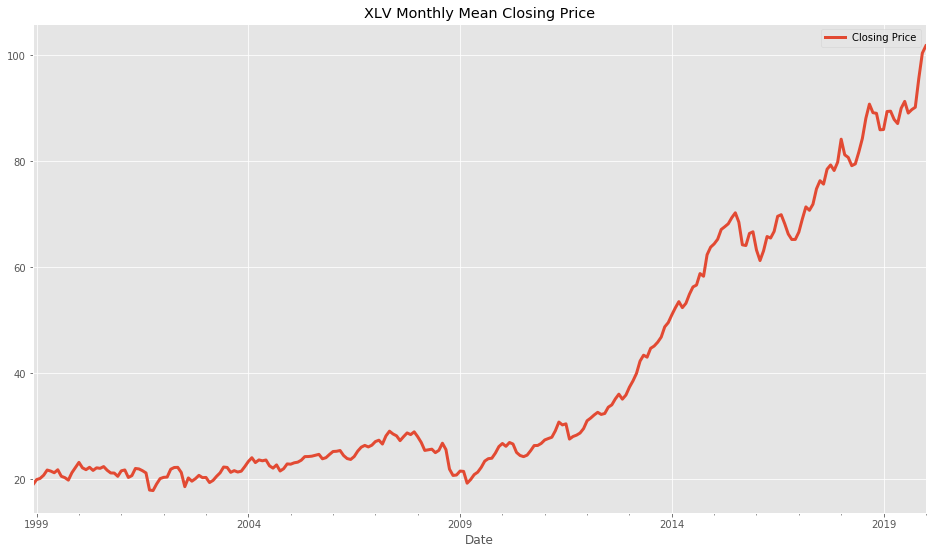

In [462]:
plt.style.use('ggplot')
fig = plt.figure(figsize = (16,9))
xlv_monthly_mean.plot(linewidth = 3, label = 'Closing Price')
plt.title('XLV Monthly Mean Closing Price')
plt.legend()
plt.show()

#There is an upwards Trend

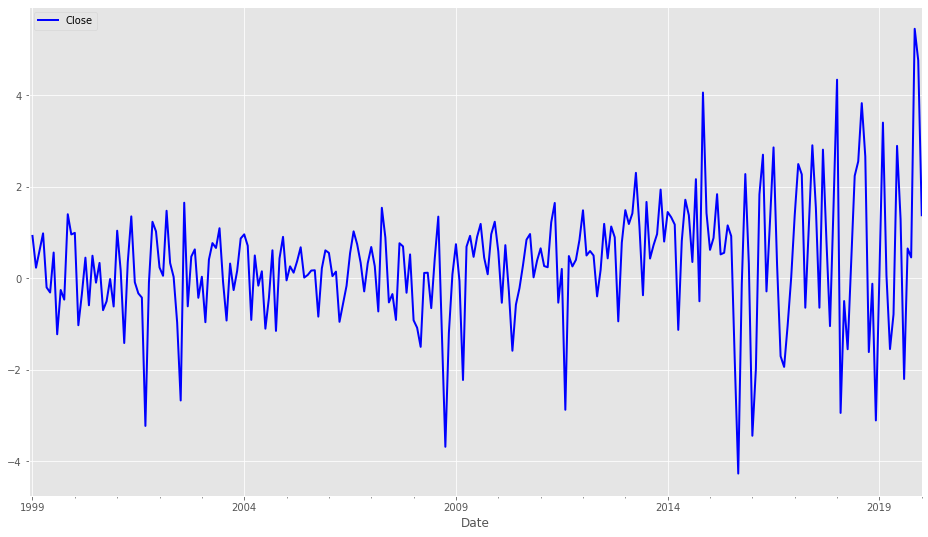

In [404]:
#Take 1st order difference of XLV
xlv_monthly_diff = xlv_monthly_mean.diff(periods = 1)
fig = plt.figure(figsize = (16, 9))
xlv_monthly_diff.plot(linewidth = 2, c = 'b')
plt.legend()
plt.show()

## Perform a Seasonal Decomposition to check for trends, seasonality, and residual distribution

In [405]:
#first order

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(xlv_monthly_mean))

In [303]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

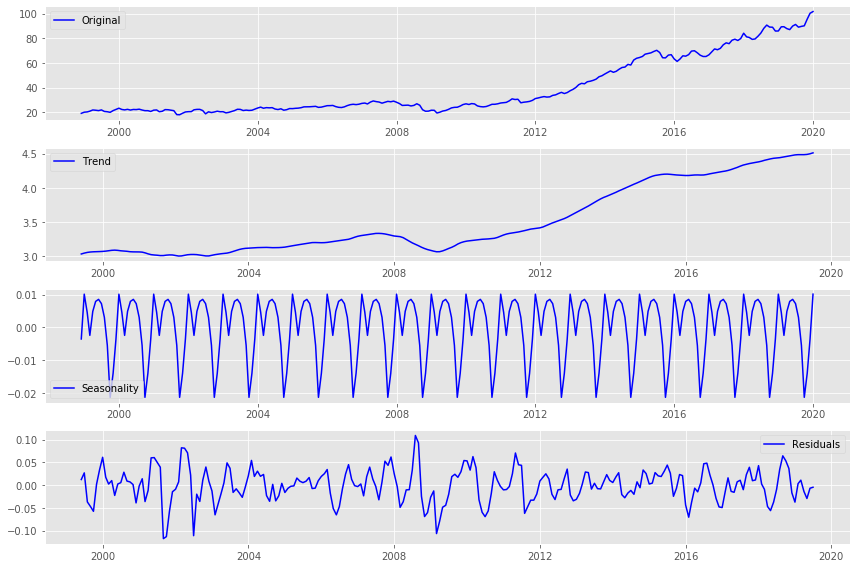

In [406]:
# Original Monthly Mean 
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(xlv_monthly_mean, label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

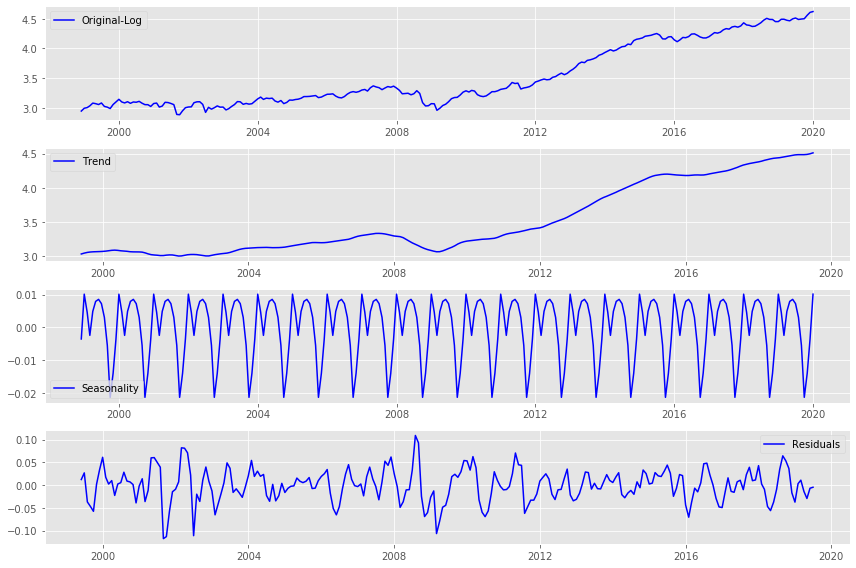

In [410]:
# Log transformation of xlv_monthly_mean
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(xlv_monthly_mean), label='Original-Log', color="blue",)
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

In [412]:
#check stationarity
def stationarity_check(TS):
    
    from statsmodels.tsa.stattools import adfuller
    rolmean = TS.rolling(window = 8, center = False).mean()
    rolstd = TS.rolling(window = 8, center = False).std()
    
    dftest = adfuller(TS)
    
    fig = plt.figure(figsize = (16,9))
    orig = plt.plot(TS, color = 'b', label = 'original')
    mean = plt.plot(rolmean, color = 'r', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
    print('Results of Dickey-Fuller Test')
    
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)
    
    return None

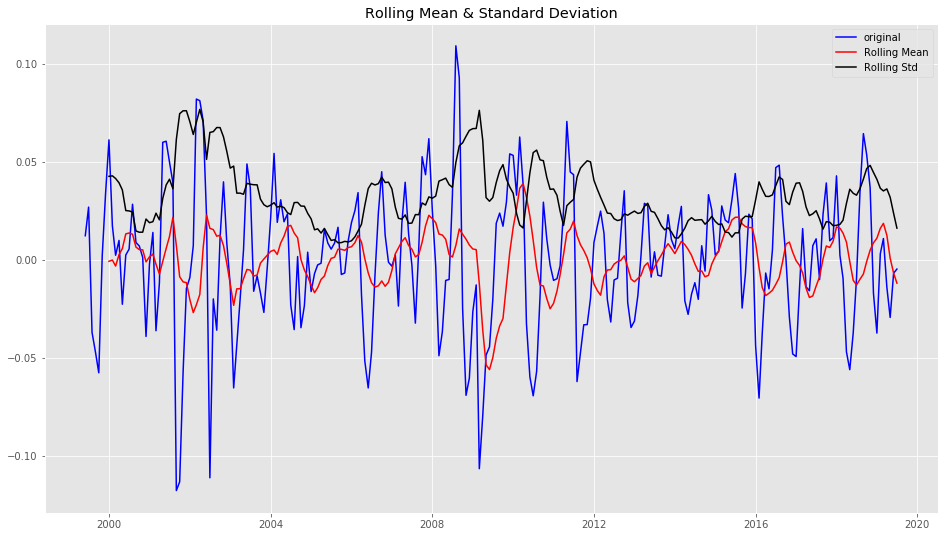

Results of Dickey-Fuller Test
Test Statistic                -7.406343e+00
p-value                        7.327849e-11
#Lags Used                     1.000000e+01
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


In [413]:
stationarity_check(xlv_log_decompose)

#### P-val = 7.32e-11 -->  Reject the null hypothesis that the data is not stationary

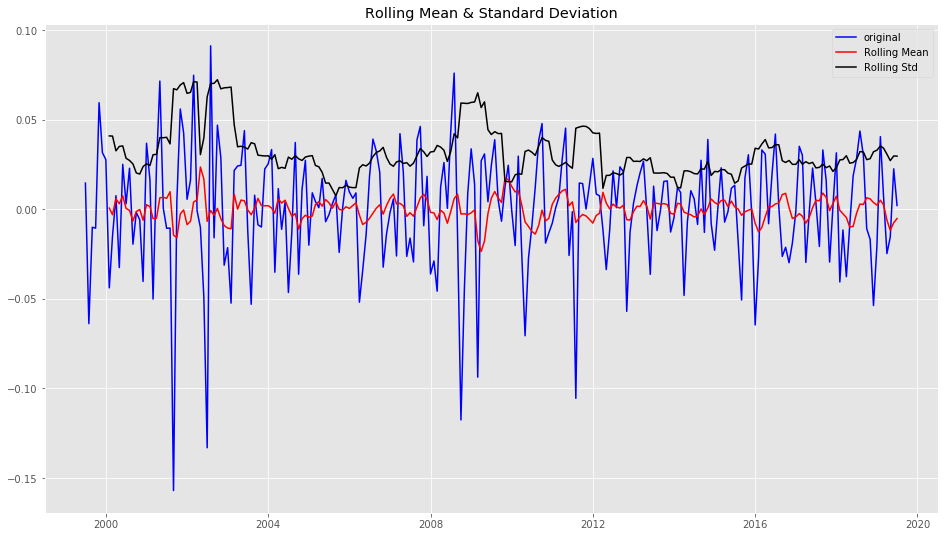

Results of Dickey-Fuller Test
Test Statistic                -8.728556e+00
p-value                        3.238267e-14
#Lags Used                     1.300000e+01
Number of Observations Used    2.270000e+02
Critical Value (1%)           -3.459490e+00
Critical Value (5%)           -2.874358e+00
Critical Value (10%)          -2.573602e+00
dtype: float64


In [423]:
#First Order Diff of Log Transformation
xlv_log_decompose_diff = xlv_log_decompose.diff(periods = 1).dropna()
stationarity_check(xlv_log_decompose_diff)

## Run ARIMA Model

### Split Model into Test/Validation
    
    

In [328]:
df_len = xlv_monthly_mean.shape[0]
df_len

254

In [333]:
xlv_monthly_mean

Date
1998-12-01     19.021429
1999-01-01     19.944737
1999-02-01     20.173684
1999-03-01     20.773913
1999-04-01     21.752857
                 ...    
2019-09-01     89.694500
2019-10-01     90.148696
2019-11-01     95.596500
2019-12-01    100.354762
2020-01-01    101.503333
Freq: MS, Name: Close, Length: 254, dtype: float64

In [372]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(xlv_monthly_mean)
X_train

Date
2017-05-01    71.858636
2015-02-01    65.261579
2009-01-01    21.555000
2001-10-01    17.880435
2005-07-01    24.365500
                ...    
1999-05-01    21.552000
2017-01-01    66.599000
2005-02-01    23.113158
2013-11-01    48.747500
2001-02-01    21.764737
Name: Close, Length: 190, dtype: float64

## ARMA: Auto-Regressive - PACF

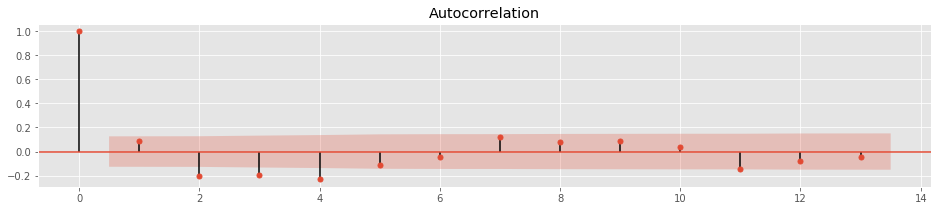

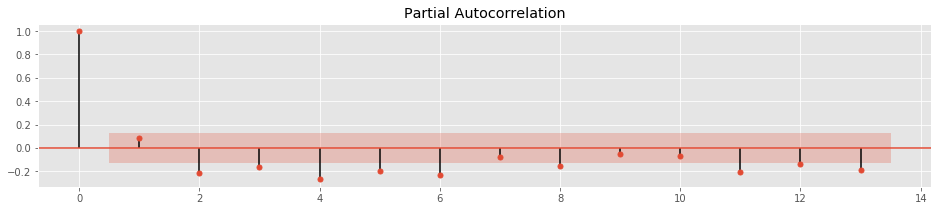

In [456]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize = (16,3))
plot_acf(xlv_log_decompose_diff, ax = ax, lags = 13);

fig, ax = plt.subplots(figsize = (16,3))
plot_pacf(xlv_log_decompose_diff, ax=ax, lags = 13);

In [457]:
### Fit ARIMA TS Model
import statsmodels.api as sm 

ARIMA_MODEL = sm.tsa.statespace.SARIMAX(X_train,
                                        order = (6, 1, 3),
                                        seasonal_order = (6, 1, 3, 12),
                                        enforce_stationarity = False,
                                        enforce_invertability = False)
output = ARIMA_MODEL.fit()
print(output.summary().tables[1])

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4381      0.363     -1.207      0.228      -1.150       0.273
ar.L2          0.2135      0.211      1.014      0.311      -0.199       0.626
ar.L3         -0.4044      0.160     -2.523      0.012      -0.718      -0.090
ar.L4         -0.4844      0.129     -3.763      0.000      -0.737      -0.232
ar.L5         -0.5102      0.172     -2.970      0.003      -0.847      -0.173
ar.L6         -0.1749      0.238     -0.733      0.463      -0.642       0.292
ma.L1         -0.4514      0.326     -1.385      0.166      -1.090       0.187
ma.L2         -0.4667      0.392     -1.190      0.234      -1.236       0.302
ma.L3          0.6399      0.254      2.522      0.012       0.143       1.137
ar.S.L12      -1.0206      0.342     -2.982      0.003      -1.691      -0.350
ar.S.L24      -0.9878      0.416     -2.376      0.0

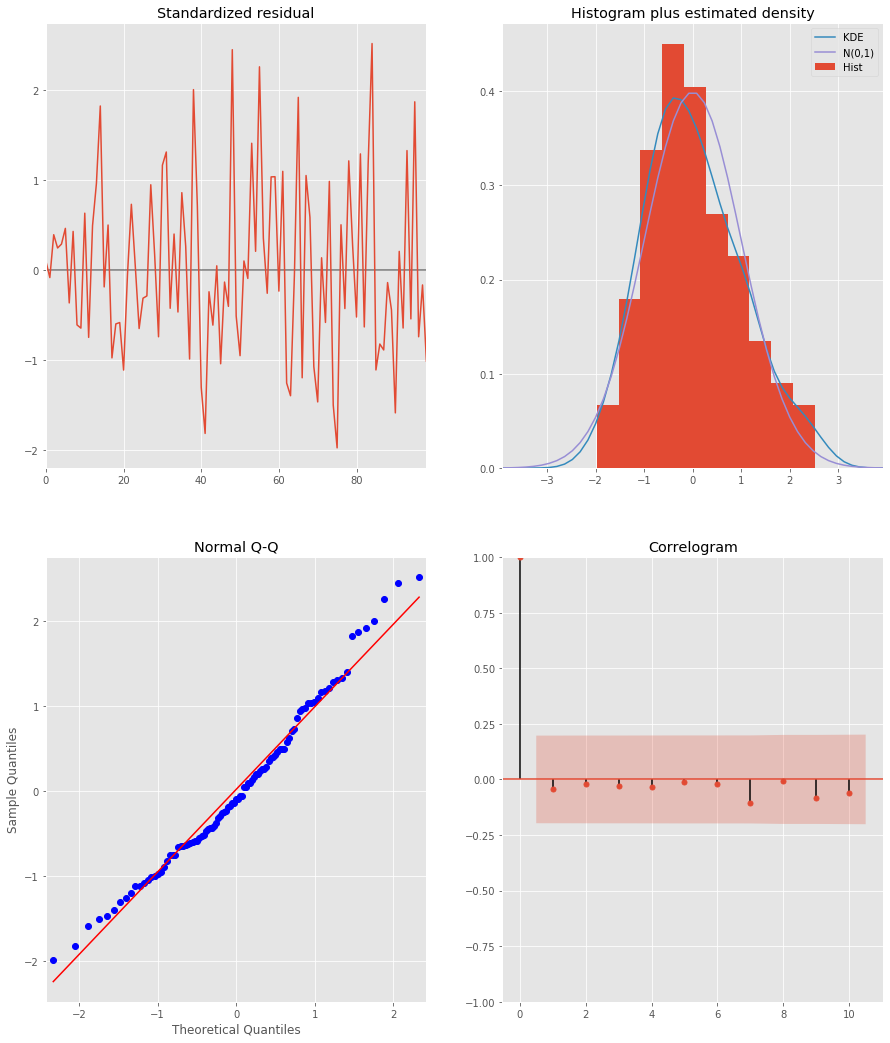

In [458]:
output.plot_diagnostics(figsize = (15, 18))
plt.show()